# Utils functions

In [1]:
import skimage.io
def load_image(image_path):
    """
    Load image with its path
    """
    return skimage.io.imread(image_path)

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
def show_image(img):
    """
    Show a single image
    """
    fig = plt.figure(figsize = (15,10))
    plt.imshow(img)

In [3]:
import numpy as np
def create_mark(rectangles, shape): # [((begin_i, begin_j), (end_i, end_j)), ...]
    """
    Using a list of rectangles, create an image of marks
    """
    marked_img = np.zeros(shape = shape, dtype=int)
    for rect in rectangles:
        for j in range(rect[0][1], rect[1][1]):
            for i in range(rect[0][0], rect[1][0]):
                marked_img[j][i][3] = 255
    return marked_img

In [4]:
import numpy as np
def apply_marks(origin, marks):
    """
    Extract numbers of the image using the marks
    """
    extract = np.zeros(shape = origin.shape[:2], dtype=bool) # all false = all black
    for i in range(origin.shape[0]):
        for j in range(origin.shape[1]):
            if marks[i][j][3] > 0 and origin[i][j][0] < 240: # if marked and object
                extract[i][j] = True # set to white
    return extract

In [5]:
import skimage.morphology
# le disk peut changer en fonction des vrai données
def fill_holes(img, elt = skimage.morphology.disk(1)):
    """
    Closure: to fill holes
    """
    if elt is None:
        return img
    return skimage.morphology.closing(img, elt)

In [6]:
import numpy as np
def get_objects(img):
    """
    From an image containing all the objects, return a list of image with a single object
    """
    tmp_img = np.copy(img) # to avoid modifying the original
    
    # list of objects
    objs = []
    
    def get_object(img, obj, i, j):
        # out of bounds
        if j > img.shape[0] or j < 0:
            return
        if i > img.shape[1] or i < 0:
            return
        # if objet
        if img[j][i]:
            obj[j][i] = True
            img[j][i] = False
            # recursive calls
            get_object(img, obj, i+1, j)
            get_object(img, obj, i, j+1)
            get_object(img, obj, i-1, j)
            get_object(img, obj, i, j-1)
    
    for j in range(tmp_img.shape[0]):
        for i in range(tmp_img.shape[1]):
            # first cell of object
            if tmp_img[j][i]:
                # create image for object
                obj = np.zeros(shape = tmp_img.shape, dtype=bool)
                # fill the image
                get_object(tmp_img, obj, i, j)
                # add to objects
                objs.append(obj)
                
    return objs

In [7]:
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
def show_images(objects, col=5):
    """
    Show a list of images (max 5 columns) = input
    """
    fig = plt.figure(figsize = (14,8))

    length = len(objects)
    
    rows = length // col + 1
    columns = col

    for i in range(length):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(objects[i])
    plt.show()

In [8]:
def get_bounding_box(img):
    min_i = img.shape[1]
    max_i = 0
    min_j = img.shape[0]
    max_j = 0
    
    for j in range(img.shape[0]):
        for i in range(img.shape[1]):
            if img[j][i]:
                if j > max_j:
                    max_j = j
                if j < min_j:
                    min_j = j
                if i > max_i:
                    max_i = i
                if i < min_i:
                    min_i = i
                    
    return ((min_i, min_j), (max_i + 1, max_j + 1))

import numpy as np
def transpose_obj_to_new_object(obj):
    """
    Create a smaller image to contain only to object
    """
    bbox = get_bounding_box(obj)
    shape = (bbox[1][1] - bbox[0][1], bbox[1][0] - bbox[0][0])
    # new image with size = bounding box
    new_obj = np.zeros(shape = shape, dtype=bool)
    
    # transpose
    for j in range(shape[0]):
        for i in range(shape[1]):
            new_obj[j][i] = obj[j + bbox[0][1]][i + bbox[0][0]]

    return new_obj

def transpose_objects(objects):
    """
    Transpose a list of objects
    """
    new_objects = []
    for obj in objects:
        # get object in a smaller image
        new_obj = transpose_obj_to_new_object(obj)
        new_objects.append(new_obj)
    return new_objects

In [9]:
# filtrer: prendre uniquement les images avec un seul nombre (fonctionne uniquement si une majorité de nombres simples)
def extract_single_numbers(images):
    # compute mean of shapes
    shapes = [arr.shape for arr in images]
    mean_shape = np.mean(shapes, axis=0)

    # apply filter
    k = mean_shape / 2
    singles, multiples = [], []
    for obj in images:
        if (mean_shape[0] - k[0] <= obj.shape[0] and obj.shape[0] <= mean_shape[0] + k[0] and mean_shape[1] - k[1] <= obj.shape[1] and obj.shape[1] <= mean_shape[1] + k[1]):
            singles.append(obj)
        else:
            multiples.append(obj)
            
    return singles, multiples

In [10]:
def turn_image(img): # turn if 3/4 * x > y
    if img.shape[0] < img.shape[1] * 0.75:
        return img[::-1].T # -90 degré # comment faire pour le sens ?
    return img

def turn_images(images):
    new_imgs = []
    for img in images:
        new_imgs.append(turn_image(img))
    return new_imgs

# With first image

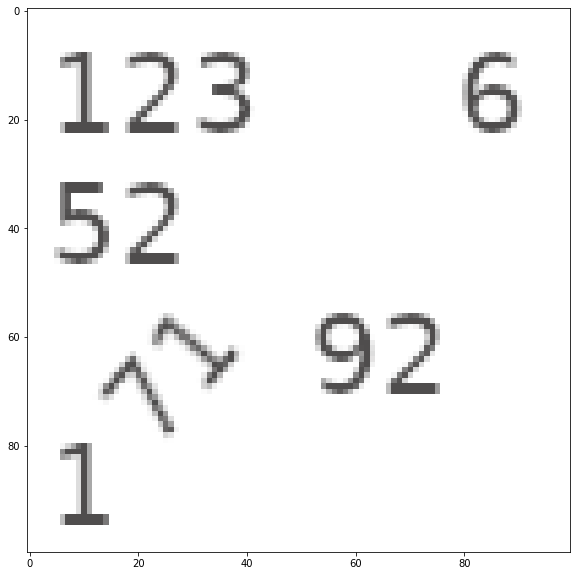

In [11]:
original = load_image("images/all-numbers.png")
show_image(original)

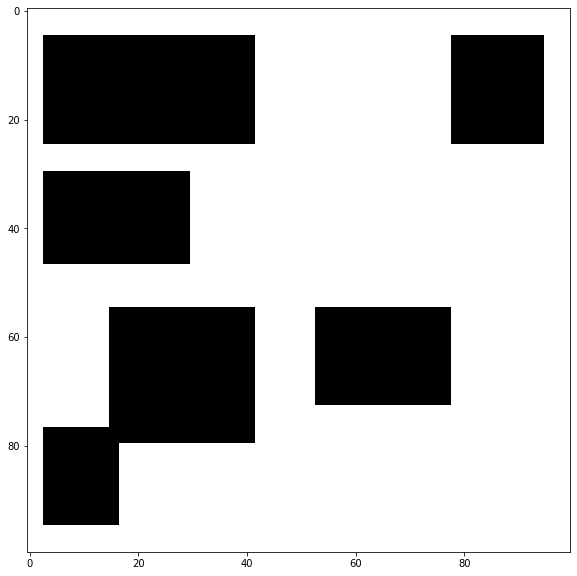

In [12]:
rectangles = [
    (
        (3, 5), (42, 25)
    ),
    (
        (78, 5), (95, 25)
    ),
    (
        (3, 30), (30, 47)
    ),
    (
        (3, 77), (17, 95)
    ),
    (
        (15, 55), (42, 80)
    ),
    (
        (53, 55), (78, 73)
    )
]
marked = create_mark(rectangles, original.shape)
show_image(marked)

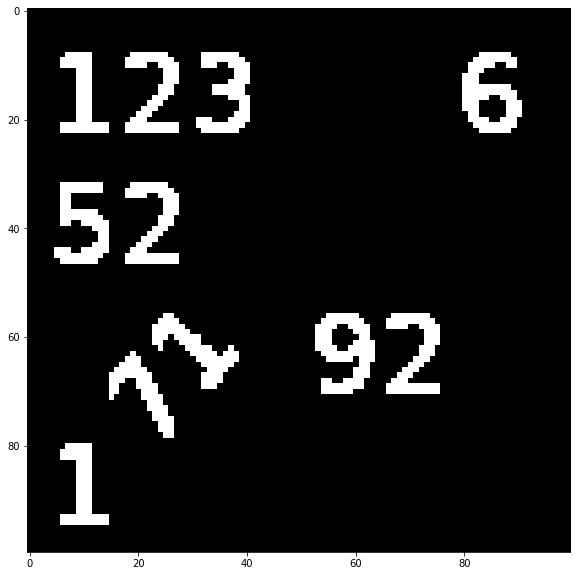

In [13]:
extracted = apply_marks(original, marked)
show_image(extracted)

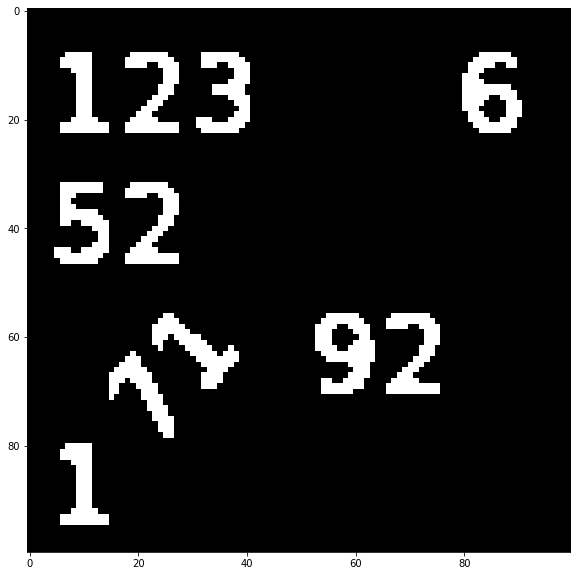

In [14]:
closed = fill_holes(extracted)
show_image(closed)

11


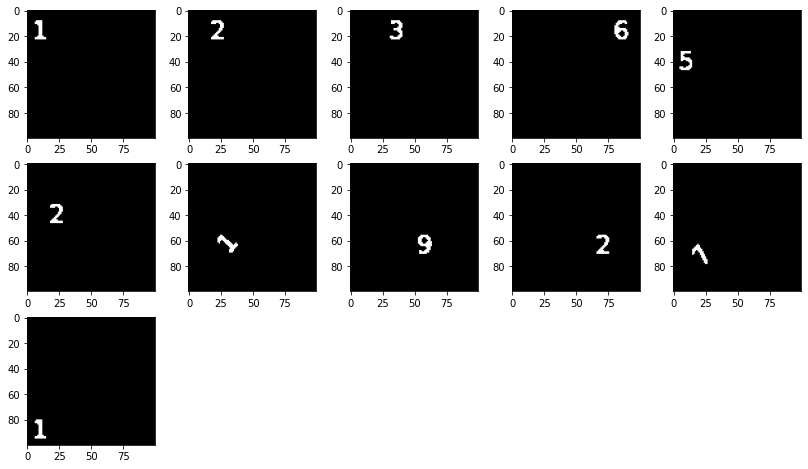

In [15]:
objects = get_objects(closed)
print(len(objects))
show_images(objects)

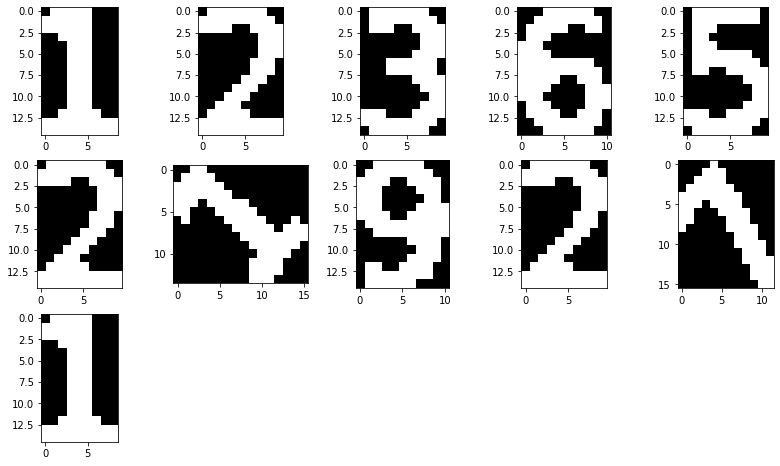

In [16]:
new_objects = transpose_objects(objects)
show_images(new_objects)

# With another image

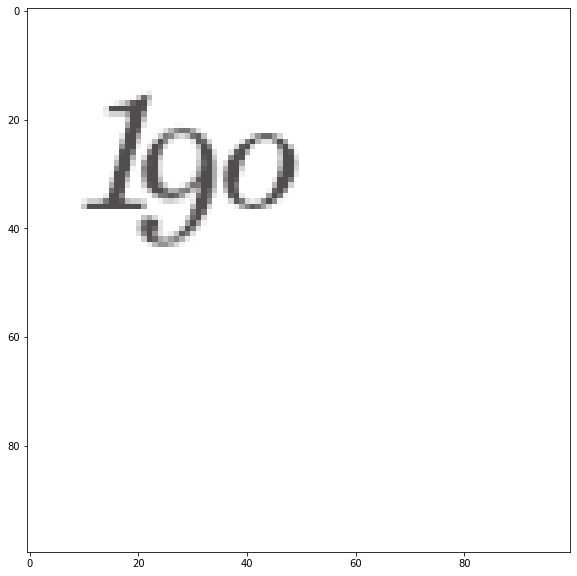

In [17]:
img2 = load_image("images/190.png")
show_image(img2)

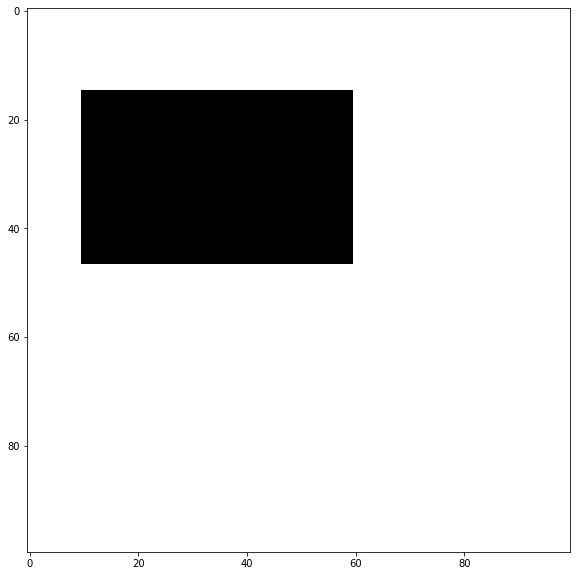

In [18]:
rectangles = [
    (
        (10, 15), (60, 47)
    )
]
marked = create_mark(rectangles, img2.shape)
show_image(marked)

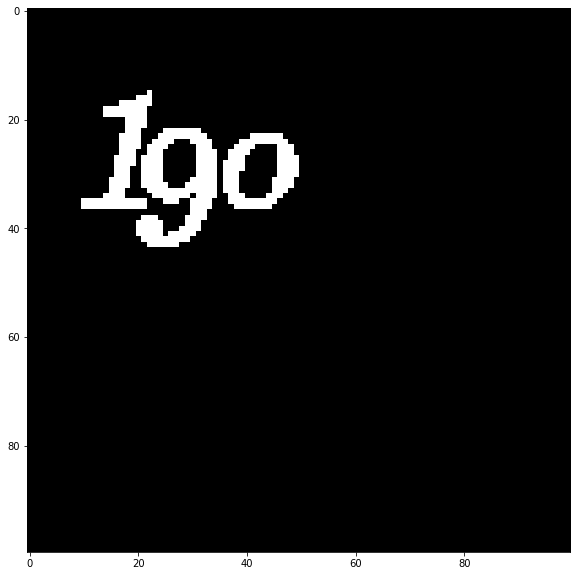

In [19]:
t = apply_marks(img2, marked)
show_image(t)

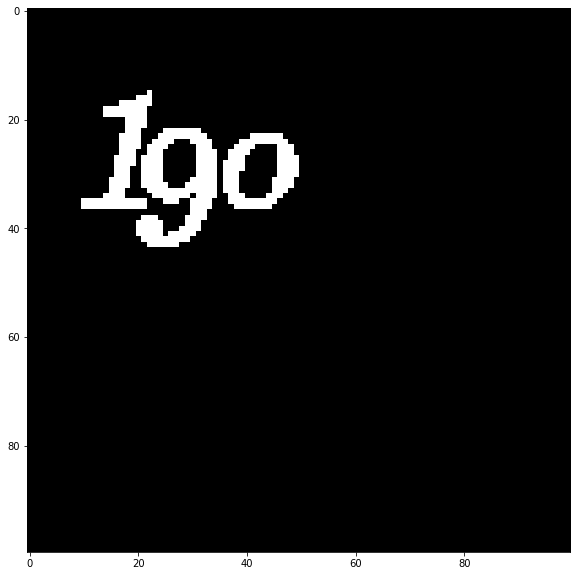

In [20]:
c = fill_holes(t, None)
show_image(c)

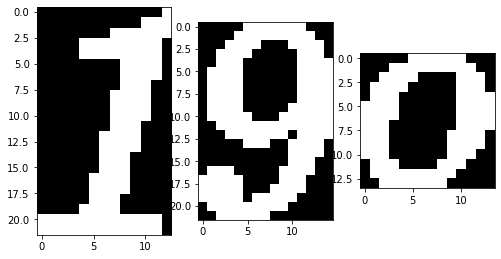

In [21]:
objects = get_objects(c)
new_objects = transpose_objects(objects)
show_images(new_objects)

# Main function

In [22]:
def process(img, marked, elt = skimage.morphology.disk(1)):
    """
    From the original image, the marks and the structural element for closure,
    return and show the resulting objects in image
    """
    extracted = apply_marks(img, marked)
    closed = fill_holes(extracted, elt)
    objects = get_objects(closed)
    new_objects = transpose_objects(objects)
    real_objects = [pixels for pixels in new_objects if not np.all(pixels)]
    singles, multiples = extract_single_numbers(real_objects)
    turned = turn_images(singles) # not necessary
    turned.extend(multiples)
    show_images(turned)
    return turned

# En 2 cells

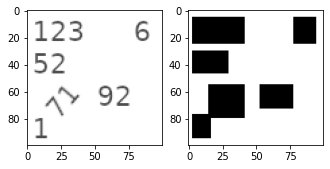

In [23]:
original = load_image("images/all-numbers.png")
rectangles = [
    (
        (3, 5), (42, 25)
    ),
    (
        (78, 5), (95, 25)
    ),
    (
        (3, 30), (30, 47)
    ),
    (
        (3, 77), (17, 95)
    ),
    (
        (15, 55), (42, 80)
    ),
    (
        (53, 55), (78, 73)
    )
]
marked = create_mark(rectangles, original.shape)
show_images([original, marked])

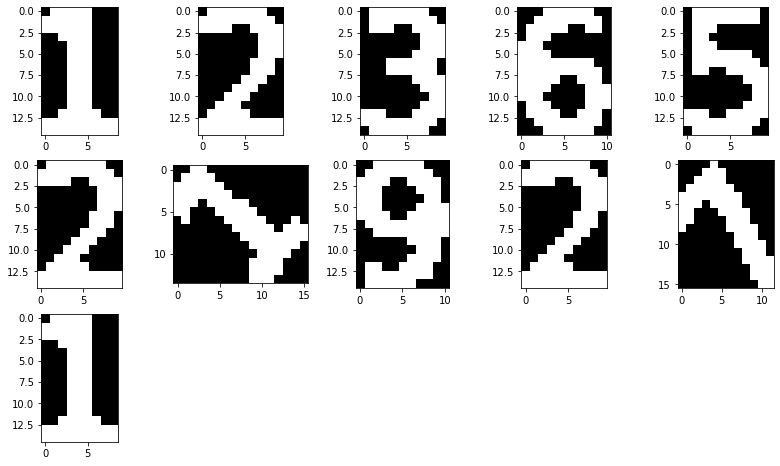

In [24]:
n = process(original, marked, skimage.morphology.disk(1))

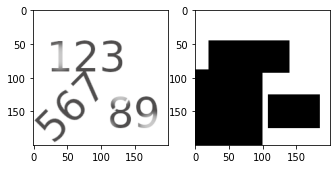

In [25]:
img2 = load_image("images/overlap-and-holes.png")
rectangles = [
    (
        (20, 45), (140, 93)
    ),
    (
        (0, 88), (100, 200)
    ),
    (
        (108, 125), (185, 175)
    )
]
marked = create_mark(rectangles, img2.shape)
show_images([img2,marked])

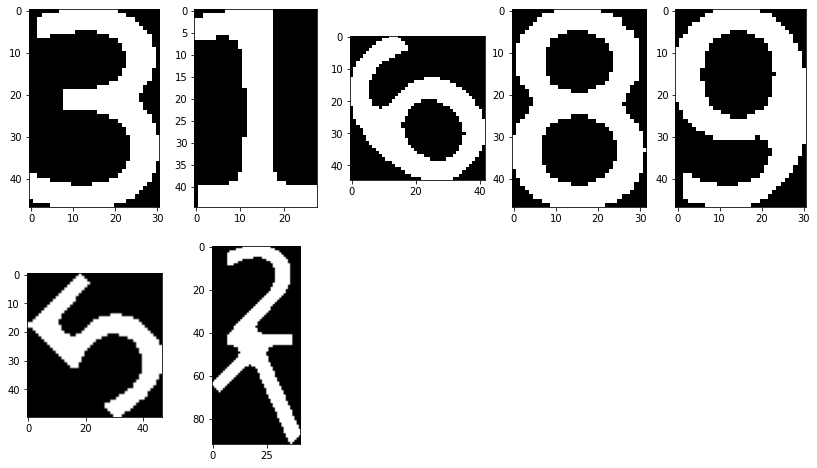

In [26]:
n = process(img2, marked, skimage.morphology.disk(3))

# With traits

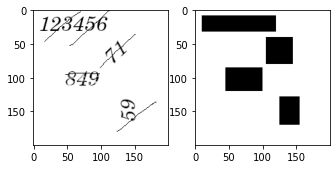

In [27]:
img3 = load_image("images/trait_rotation.png")
rectangles = [
    (
        (10, 8), (120, 32)
    ),
    (
        (105, 40), (145, 80)
    ),
    (
        (45, 85), (100, 120)
    ),
    (
        (125, 128), (155, 170)
    ),
]
marked = create_mark(rectangles, img3.shape)
show_images([img3, marked])

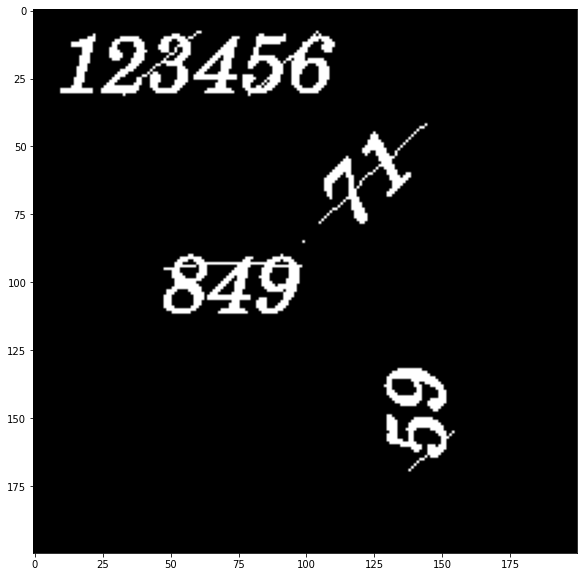

In [28]:
extracted = apply_marks(img3, marked)
show_image(extracted)

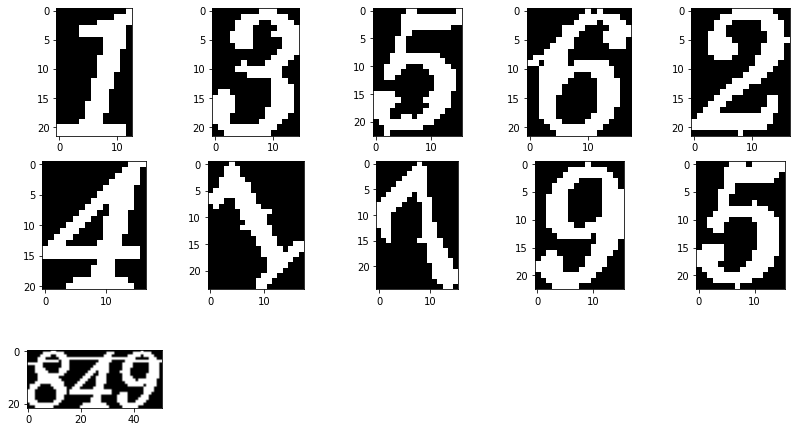

In [29]:
n = process(img3, marked, skimage.morphology.disk(0))

# TODO:

- Gérer les overlap

In [30]:
# if len(img) > 1.5 * moyenne:
#     surement un overlap, coupe en 2 ?
# utiliser le squelette ?

# Squelette

Comment je peux découper ces nombres ?

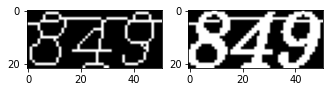

In [31]:
skelet = skimage.morphology.skeletonize(n[-1])
show_images([skelet, n[-1]])